In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Loading data

In [16]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


## Feature Engineering

In [8]:
print("\n=== CROSS-SECTIONAL FEATURE ENGINEERING ===")

def create_cross_sectional_features(train):
    """
    Create features that exploit relative stock performance (compare stock performance at a point of time rather than comparing with historical values)
    """
    df = train.copy()
    
    # 1. RANK-BASED FEATURES 
    if 'DATE' in df.columns:
        for col in ['RET_1', 'RET_5', 'RET_10', 'RET_20']:
            # Convert absolute value -> percentile rank within each date
            df[f'{col}_RANK'] = df.groupby('DATE')[col].rank(pct=True)
            
            # Z-score within each date (neutralizes market effect, standardizes returns)
            df[f'{col}_ZSCORE'] = df.groupby('DATE')[col].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
    
    # 2. VOLATILITY-ADJUSTED RETURNS
    ret_cols = [f'RET_{i}' for i in range(1, 21)]
    df['RET_STD_20'] = df[ret_cols].std(axis=1)
    df['RET_MEAN_20'] = df[ret_cols].mean(axis=1)
    df['SHARPE_20'] = df['RET_MEAN_20'] / (df['RET_STD_20'] + 1e-8) # Create Sharpe ratio-like feature
    
    # 3. MOMENTUM INDICATORS (trend strength)
    df['MOMENTUM_SHORT'] = df['RET_1'] - df['RET_5']
    df['MOMENTUM_LONG'] = df['RET_5'] - df['RET_20']
    df['ACCELERATION'] = df['MOMENTUM_SHORT'] - df['MOMENTUM_LONG']
    
    # 4. EXTREMES (potential mean reversals)
    df['RET_MAX_20'] = df[ret_cols].max(axis=1)
    df['RET_MIN_20'] = df[ret_cols].min(axis=1)
    df['IS_EXTREME_HIGH'] = (df['RET_1'] == df['RET_MAX_20']).astype(int)
    df['IS_EXTREME_LOW'] = (df['RET_1'] == df['RET_MIN_20']).astype(int)
    
    # 5. VOLUME FEATURES
    vol_cols = [f'VOLUME_{i}' for i in range(1, 21) if f'VOLUME_{i}' in df.columns]
    if len(vol_cols) > 0:
        df['VOLUME_MEAN_20'] = df[vol_cols].mean(axis=1)
        df['VOLUME_STD_20'] = df[vol_cols].std(axis=1)
        df['VOLUME_SPIKE'] = df['VOLUME_1'] / (df['VOLUME_MEAN_20'] + 1e-8)
        
        if 'DATE' in df.columns:
            df['VOLUME_1_RANK'] = df.groupby('DATE')['VOLUME_1'].rank(pct=True)
    
    return df

# Apply
train_engineered = create_cross_sectional_features(train)
new_features = [col for col in train_engineered.columns if col not in train.columns]
print(f"\nCreated {len(new_features)} features")



=== CROSS-SECTIONAL FEATURE ENGINEERING ===

Created 22 features


In [10]:
df = train_engineered.copy()

# Identify numeric feature columns (exclude target explicitly)
target_col = 'RET'
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)

X_all = df[num_cols]
y = df[target_col]

print(f"Total numeric features (old + new): {len(num_cols)}")

# -----------------------------------------------------------------------------
# 2. Correlation of each feature with RET
# -----------------------------------------------------------------------------
feature_corr = X_all.corrwith(y).sort_values(ascending=False)
print("\n=== FEATURE–TARGET CORRELATIONS (ALL FEATURES) ===")
print(feature_corr)

# If you want to see top/bottom N by absolute value:
N = 20
feature_corr_abs_sorted = feature_corr.reindex(
    feature_corr.abs().sort_values(ascending=False).index
)
print(f"\n=== TOP {N} FEATURES BY |CORR| WITH RET ===")
print(feature_corr_abs_sorted.head(N))


Total numeric features (old + new): 68

=== FEATURE–TARGET CORRELATIONS (ALL FEATURES) ===
VOLUME_1_RANK     0.023099
RET_MIN_20        0.012525
RET_10_RANK       0.011948
IS_EXTREME_LOW    0.009309
RET_10_ZSCORE     0.008101
                    ...   
MOMENTUM_SHORT   -0.013864
RET_17           -0.014077
RET_1            -0.016845
RET_1_ZSCORE     -0.019352
RET_1_RANK       -0.022052
Length: 68, dtype: float64

=== TOP 20 FEATURES BY |CORR| WITH RET ===
VOLUME_1_RANK      0.023099
RET_1_RANK        -0.022052
RET_1_ZSCORE      -0.019352
RET_1             -0.016845
RET_17            -0.014077
MOMENTUM_SHORT    -0.013864
RET_MIN_20         0.012525
RET_16            -0.012448
RET_10_RANK        0.011948
ACCELERATION      -0.010814
IS_EXTREME_LOW     0.009309
RET_2             -0.009127
IS_EXTREME_HIGH   -0.009124
RET_MEAN_20       -0.008520
RET_8             -0.008396
RET_10_ZSCORE      0.008101
RET_STD_20        -0.007167
RET_13            -0.005953
RET_7              0.005828
RET_10   

All correlations are in the ±0.02 range. 

Top highly correlated features that can be used: 
- Short‑term reversal: RET_1_RANK, RET_1_ZSCORE, RET_1, MOMENTUM_SHORT, ACCELERATION (Stock that outperform yesterday might underperform today, and vice versa <- overraction + correction)
- Volume: VOLUME_1_RANK (high relative volume ++ winning <- informed trading/attention effect)
- Medium‑term momentum: RET_10_RANK, RET_10_ZSCORE
- Extremes / oversold: RET_MIN_20, IS_EXTREME_LOW, IS_EXTREME_HIGH (being at/near low/high tends to be followed by outperf/underperf)
- Risk/level proxies: RET_MEAN_20, RET_STD_20 
- Some individual lags: RET_17, RET_16, RET_8, RET_7, RET_10, RET_2

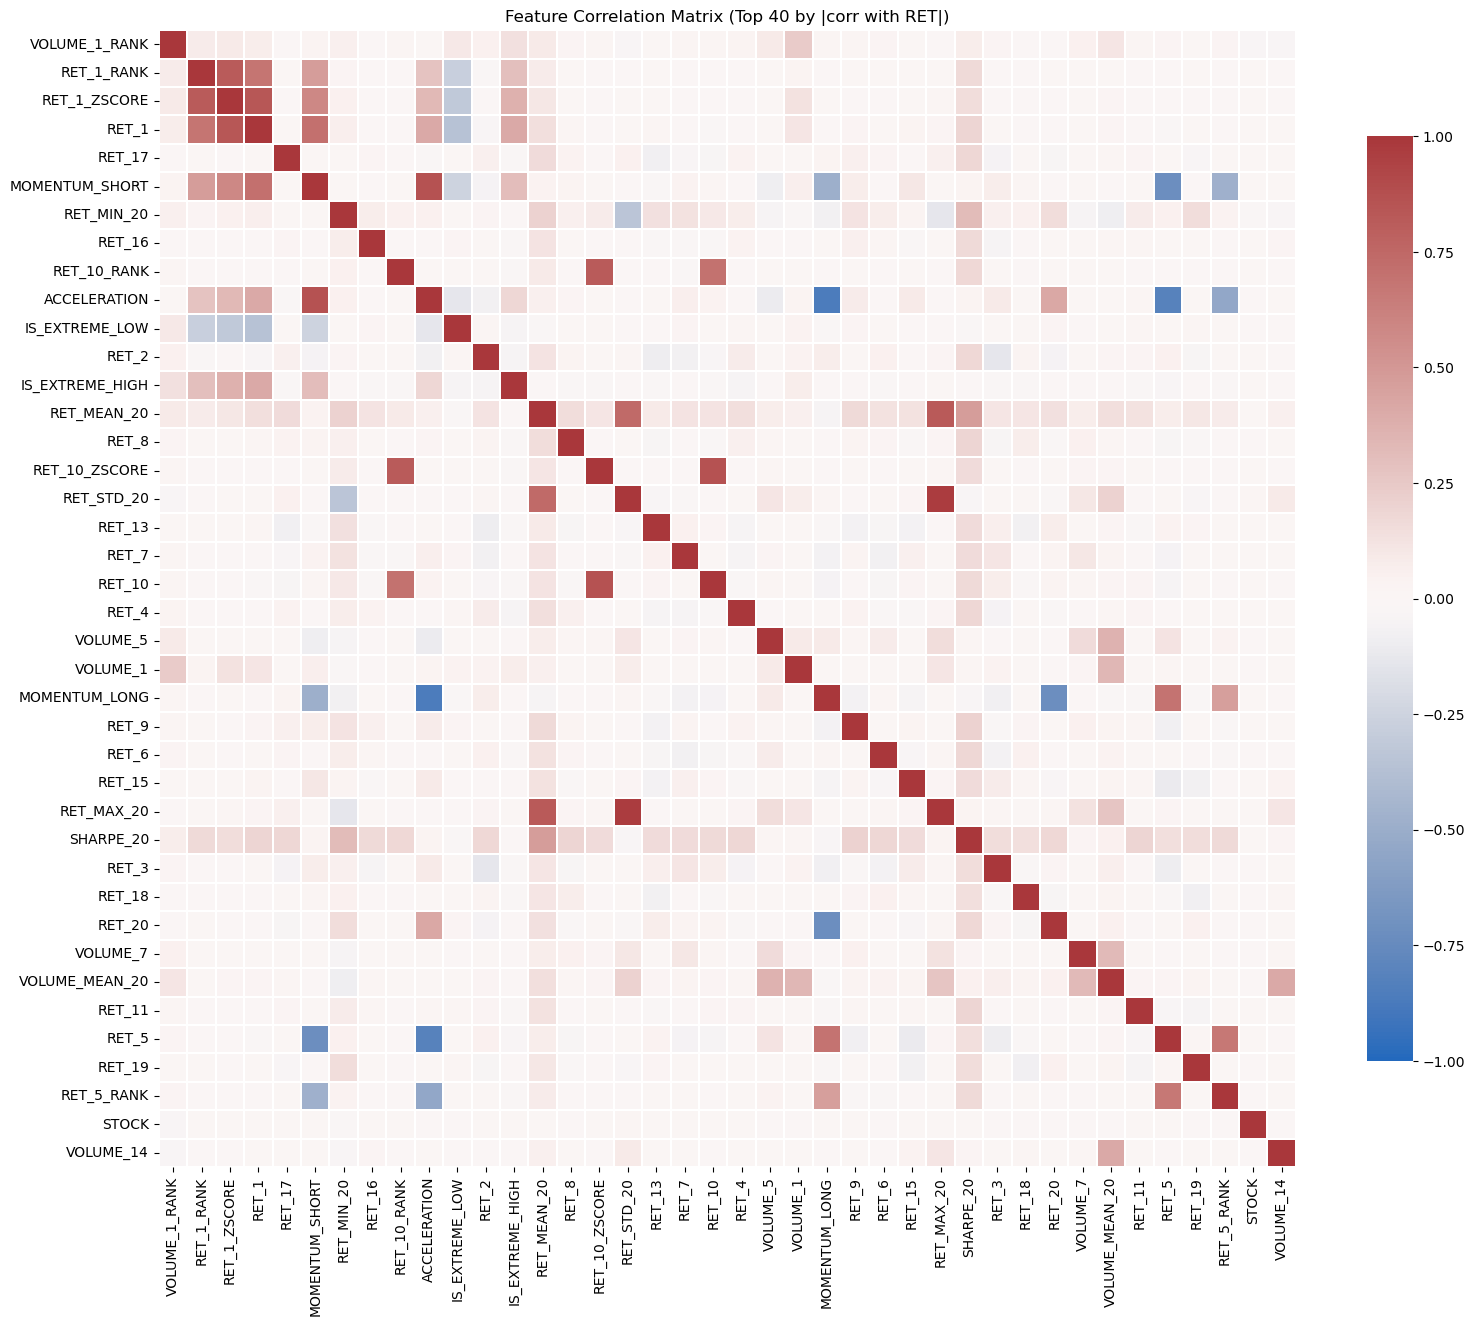

In [11]:
# -----------------------------------------------------------------------------
# 3. Correlation matrix between numeric features
# -----------------------------------------------------------------------------
corr_matrix = X_all.corr()

K = 40  # change as needed
top_k_features = feature_corr_abs_sorted.head(K).index.tolist()
corr_top_k = X_all[top_k_features].corr()

# -----------------------------------------------------------------------------
# 4. Plot heatmap of correlation matrix (top K features)
# -----------------------------------------------------------------------------
plt.figure(figsize=(max(10, K * 0.4), max(8, K * 0.4)))
sns.heatmap(
    corr_top_k,
    cmap='vlag',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.3,
    cbar_kws={'shrink': 0.6}
)
plt.title(f'Feature Correlation Matrix (Top {K} by |corr with RET|)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Model

In [22]:
tscv = TimeSeriesSplit(n_splits=5)

print("\n=== BASELINE: XGBoost with Original Features Only (from 'train') ===")

# Original features = everything in train except RET (no engineered features)
original_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if target_col in original_cols:
    original_cols.remove(target_col)

print(f"Using {len(original_cols)} original features")

baseline_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all)):  # Uses same indices as X_all
    # Baseline: use ORIGINAL features only
    X_train_fold = train.iloc[train_idx][original_cols]
    X_test_fold  = train.iloc[test_idx][original_cols]
    y_train_fold = y.iloc[train_idx]
    y_test_fold  = y.iloc[test_idx]

    # Impute within fold
    imputer = SimpleImputer(strategy='median') 
    X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_fold), 
                              columns=original_cols, index=X_train_fold.index)
    X_test_imp  = pd.DataFrame(imputer.transform(X_test_fold), 
                              columns=original_cols, index=X_test_fold.index)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled  = scaler.transform(X_test_imp)

    # Model
    model = xgb.XGBClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'
    )
    model.fit(X_train_scaled, y_train_fold, verbose=False)
    
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_fold, y_pred)
    auc = roc_auc_score(y_test_fold, y_prob)
    baseline_results.append({'Fold': fold+1, 'Accuracy': acc, 'AUC': auc})
    print(f"Fold {fold+1}: Acc={acc:.4f}, AUC={auc:.4f}")

baseline_df = pd.DataFrame(baseline_results)
print(f"\nBaseline Mean: Acc={baseline_df['Accuracy'].mean():.4f} ± {baseline_df['Accuracy'].std():.4f}")
print(f"               AUC={baseline_df['AUC'].mean():.4f} ± {baseline_df['AUC'].std():.4f}")



=== BASELINE: XGBoost with Original Features Only (from 'train') ===
Using 46 original features
Fold 1: Acc=0.4995, AUC=0.5035
Fold 2: Acc=0.5116, AUC=0.5172
Fold 3: Acc=0.5110, AUC=0.5138
Fold 4: Acc=0.5146, AUC=0.5188
Fold 5: Acc=0.4963, AUC=0.4951

Baseline Mean: Acc=0.5066 ± 0.0081
               AUC=0.5097 ± 0.0101


KNN Imputer took long to run, so for the baseline case I replaced it with SimpleImputer for simplicity, the results of 2 methods were quite similar. 

In [33]:
print("\n=== IMPROVED: XGBoost with ALL Engineered Features (X_all) ===")

improved_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all)):
    X_train_fold = X_all.iloc[train_idx]
    X_test_fold  = X_all.iloc[test_idx]
    y_train_fold = y.iloc[train_idx]
    y_test_fold  = y.iloc[test_idx]

    # Impute
    imputer = SimpleImputer(strategy='median') 
    X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_fold), 
                              columns=X_all.columns, index=X_train_fold.index)
    X_test_imp  = pd.DataFrame(imputer.transform(X_test_fold), 
                              columns=X_all.columns, index=X_test_fold.index)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled  = scaler.transform(X_test_imp)

    # Slightly larger model
    model = xgb.XGBClassifier(
        n_estimators=150, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.7, random_state=42, eval_metric='logloss'
    )
    model.fit(X_train_scaled, y_train_fold, verbose=False)
    
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_fold, y_pred)
    auc = roc_auc_score(y_test_fold, y_prob)
    improved_results.append({'Fold': fold+1, 'Accuracy': acc, 'AUC': auc})
    print(f"Fold {fold+1}: Acc={acc:.4f}, AUC={auc:.4f}")

improved_df = pd.DataFrame(improved_results)
print(f"\nImproved Mean: Acc={improved_df['Accuracy'].mean():.4f} ± {improved_df['Accuracy'].std():.4f}")
print(f"               AUC={improved_df['AUC'].mean():.4f} ± {improved_df['AUC'].std():.4f}")


=== IMPROVED: XGBoost with ALL Engineered Features (X_all) ===
Fold 1: Acc=0.4988, AUC=0.4771
Fold 2: Acc=0.5148, AUC=0.5226
Fold 3: Acc=0.5123, AUC=0.5176
Fold 4: Acc=0.5176, AUC=0.5224
Fold 5: Acc=0.5007, AUC=0.4998

Improved Mean: Acc=0.5088 ± 0.0085
               AUC=0.5079 ± 0.0196


In [28]:
# Improvement
acc_improvement = (improved_df['Accuracy'].mean() - baseline_df['Accuracy'].mean()) * 100
auc_improvement = (improved_df['AUC'].mean() - baseline_df['AUC'].mean()) * 100
print(f"\n{'='*60}")
print(f"ACCURACY IMPROVEMENT: +{acc_improvement:.2f} percentage points")
print(f"AUC IMPROVEMENT: +{auc_improvement:.2f} percentage points")
print(f"{'='*60}")

# Feature importance (from last improved fold)
feature_importance = pd.DataFrame({
    'Feature': X_all.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== TOP 20 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(20).to_string())

engineered_tokens = ['_RANK', '_ZSCORE', 'MOMENTUM', 'SHARPE', 'EXTREME', 'SPIKE', 'ACCELERATION']
engineered_in_top10 = feature_importance.head(10)['Feature'].apply(
    lambda x: any(tok in x for tok in engineered_tokens)
).sum()
print(f"\nEngineered features in top 10: {engineered_in_top10}/10")


ACCURACY IMPROVEMENT: +0.22 percentage points
AUC IMPROVEMENT: +-0.18 percentage points

=== TOP 20 MOST IMPORTANT FEATURES ===
           Feature  Importance
54      RET_STD_20    0.037890
0             DATE    0.027718
3   INDUSTRY_GROUP    0.027110
60      RET_MAX_20    0.024181
1            STOCK    0.022233
47    RET_1_ZSCORE    0.021281
7         VOLUME_1    0.020813
61      RET_MIN_20    0.020535
59    ACCELERATION    0.018554
55     RET_MEAN_20    0.018168
2         INDUSTRY    0.018016
57  MOMENTUM_SHORT    0.017869
64  VOLUME_MEAN_20    0.017489
12           RET_4    0.017214
5     SUB_INDUSTRY    0.017134
38          RET_17    0.016994
10           RET_3    0.016806
4           SECTOR    0.016629
67   VOLUME_1_RANK    0.016594
6            RET_1    0.016016

Engineered features in top 10: 2/10


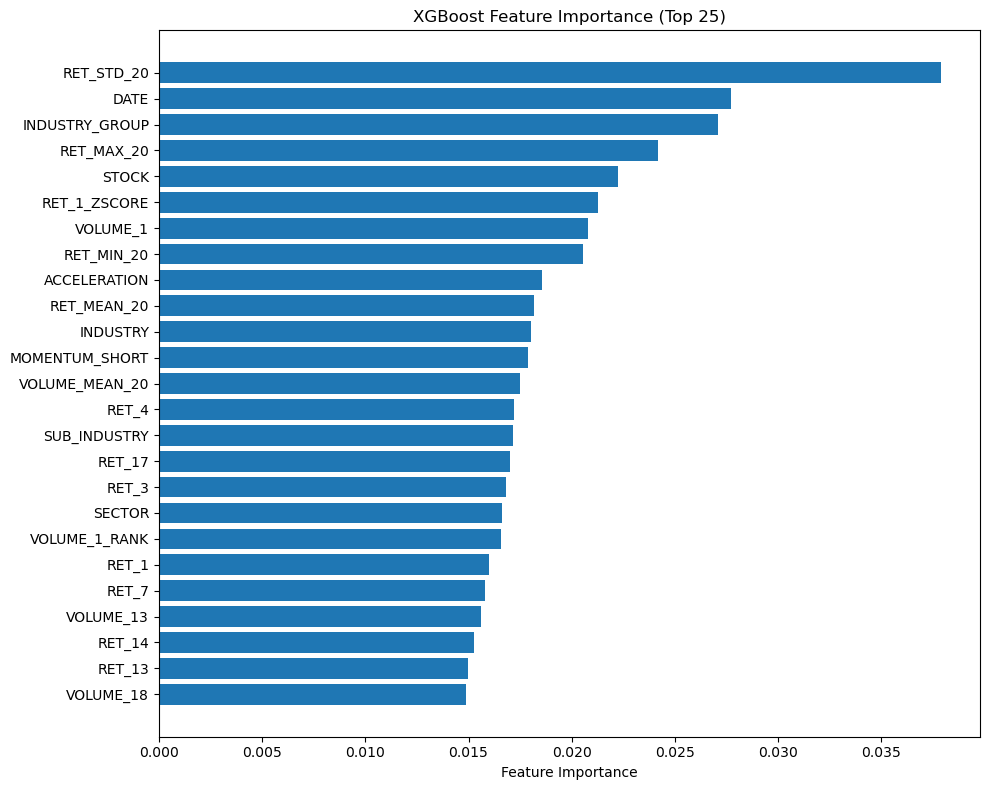

In [29]:
top_features = feature_importance.head(25)

# Plot 1: Horizontal bar chart (best for reading feature names)
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (Top 25)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

Modest improvement after feature engineering (+0.22 AC, -0.18pp AUC loss, with only 2 engineered features in top 10). 
- Vol and momentum variables are predictive
- Categorical variables like DATE and STOCK are too predictive? -> Leakage?

# Retrain to check leakage

In [34]:
df_sorted = df.sort_values('DATE').reset_index(drop=True)
X_all_sorted = X_all.loc[df_sorted.index]
y_sorted = y.loc[df_sorted.index]
print("=== CLEAN MODEL: No Leakage Columns ===")

# Define leakage columns (identifiers that create proxy signals)
leak_cols = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']

# Create clean feature matrix
X_clean = X_all_sorted.drop(columns=leak_cols, errors='ignore')
print(f"Clean features: {len(X_clean.columns)} (dropped {len([c for c in leak_cols if c in X_all_sorted.columns])} leakage cols)")

clean_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_clean)):
    X_train_fold = X_clean.iloc[train_idx]
    X_test_fold  = X_clean.iloc[test_idx]
    y_train_fold = y_sorted.iloc[train_idx]  # Use sorted y
    y_test_fold  = y_sorted.iloc[test_idx]

    # SimpleImputer (fast)
    imputer = SimpleImputer(strategy='median')
    X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_fold), 
                              columns=X_clean.columns, index=X_train_fold.index)
    X_test_imp  = pd.DataFrame(imputer.transform(X_test_fold), 
                              columns=X_clean.columns, index=X_test_fold.index)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled  = scaler.transform(X_test_imp)

    # SAME model as improved baseline (fair comparison)
    model_clean = xgb.XGBClassifier(
        n_estimators=150, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.7, random_state=42, eval_metric='logloss'
    )
    model_clean.fit(X_train_scaled, y_train_fold, verbose=False)
    
    y_pred = model_clean.predict(X_test_scaled)
    y_prob = model_clean.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_fold, y_pred)
    auc = roc_auc_score(y_test_fold, y_prob)
    clean_results.append({'Fold': fold+1, 'Accuracy': acc, 'AUC': auc})
    print(f"Fold {fold+1}: Acc={acc:.4f}, AUC={auc:.4f}")

clean_df = pd.DataFrame(clean_results)
print(f"\nClean Mean: Acc={clean_df['Accuracy'].mean():.4f} ± {clean_df['Accuracy'].std():.4f}")
print(f"          AUC={clean_df['AUC'].mean():.4f} ± {clean_df['AUC'].std():.4f}")

# Feature importance
feature_importance_clean = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance': model_clean.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== TOP 20 CLEAN FEATURE IMPORTANCE ===")
print(feature_importance_clean.head(20).to_string())

# Count engineered in top 10
engineered_in_top10_clean = feature_importance_clean.head(10)['Feature'].apply(
    lambda x: any(tok in x for tok in ['_RANK', '_ZSCORE', 'MOMENTUM', 'SHARPE', 'EXTREME', 'SPIKE', 'ACCELERATION'])
).sum()
print(f"\nClean - Engineered features in top 10: {engineered_in_top10_clean}/10")

# =============================================================================
# COMPARISON TABLE
# =============================================================================
print("\n" + "="*80)
print("RESULTS COMPARISON")
print("="*80)
comparison = pd.DataFrame({
    'Metric': ['Accuracy Mean', 'Accuracy Std', 'AUC Mean', 'AUC Std', 'Engineered Top10'],
    'Original (w/ leakage)': [
        f"{baseline_df['Accuracy'].mean():.4f}",
        f"{baseline_df['Accuracy'].std():.4f}",
        f"{baseline_df['AUC'].mean():.4f}",
        f"{baseline_df['AUC'].std():.4f}",
        f"{2}/10"
    ],
    'Improved (w/ leakage)': [
        f"{improved_df['Accuracy'].mean():.4f}",
        f"{improved_df['Accuracy'].std():.4f}",
        f"{improved_df['AUC'].mean():.4f}",
        f"{improved_df['AUC'].std():.4f}",
        f"{2}/10"
    ],
    'Clean (no leakage)': [
        f"{clean_df['Accuracy'].mean():.4f}",
        f"{clean_df['Accuracy'].std():.4f}",
        f"{clean_df['AUC'].mean():.4f}",
        f"{clean_df['AUC'].std():.4f}",
        f"{engineered_in_top10_clean}/10"
    ]
})
print(comparison.to_string(index=False))
print("="*80)


=== CLEAN MODEL: No Leakage Columns ===
Clean features: 62 (dropped 6 leakage cols)
Fold 1: Acc=0.5240, AUC=0.5326
Fold 2: Acc=0.5171, AUC=0.5211
Fold 3: Acc=0.5162, AUC=0.5187
Fold 4: Acc=0.5179, AUC=0.5242
Fold 5: Acc=0.4958, AUC=0.4950

Clean Mean: Acc=0.5142 ± 0.0107
          AUC=0.5183 ± 0.0141

=== TOP 20 CLEAN FEATURE IMPORTANCE ===
            Feature  Importance
48       RET_STD_20    0.049520
41     RET_1_ZSCORE    0.023335
1          VOLUME_1    0.023081
32           RET_17    0.021590
58   VOLUME_MEAN_20    0.021549
53     ACCELERATION    0.021493
4             RET_3    0.020198
54       RET_MAX_20    0.020148
49      RET_MEAN_20    0.020142
55       RET_MIN_20    0.020062
61    VOLUME_1_RANK    0.018531
40       RET_1_RANK    0.018212
6             RET_4    0.017742
8             RET_5    0.017348
25        VOLUME_13    0.017157
31        VOLUME_16    0.017060
5          VOLUME_3    0.016942
56  IS_EXTREME_HIGH    0.016832
22           RET_12    0.016628
16            RET

Performance drop after removing is minimal and even improved -> Categoricals were adding noise rather than causing leakage
-> Should be stricter with feature selection to reduce noise

High variance across folds -> Features work well in some markets but not others -> Regime-specific patterns?

We can consider:
- More vol features
- Regime dependency features
- More statistical transforms: Skewness, kurtosis of returns
- Market relative features: Stock return vs industry average



# Retrain with different feature selection

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

def run_cv(X, y, imputer, model, name="model"):
    results = []
    last_model = None

    for fold, (tr, te) in enumerate(tscv.split(X), start=1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        # impute
        X_tr_imp = imputer.fit_transform(X_tr)
        X_te_imp = imputer.transform(X_te)

        # scale
        scaler = StandardScaler()
        X_tr_sc = scaler.fit_transform(X_tr_imp)
        X_te_sc = scaler.transform(X_te_imp)

        # fit + eval
        model.fit(X_tr_sc, y_tr, verbose=False)
        last_model = model  # keep reference to model from this fold

        y_pred = model.predict(X_te_sc)
        y_prob = model.predict_proba(X_te_sc)[:, 1]

        acc = accuracy_score(y_te, y_pred)
        auc = roc_auc_score(y_te, y_prob)
        results.append({"Fold": fold, "Accuracy": acc, "AUC": auc})
        print(f"{name} | Fold {fold}: Acc={acc:.4f}, AUC={auc:.4f}")

    df_res = pd.DataFrame(results)
    print(f"\n{name} Mean:  Acc={df_res['Accuracy'].mean():.4f} ± {df_res['Accuracy'].std():.4f}")
    print(f"{' ' * len(name)}       AUC={df_res['AUC'].mean():.4f} ± {df_res['AUC'].std():.4f}")

    # ----- feature importance from last fold -----
    feat_imp = pd.DataFrame({
        "Feature": X.columns,
        "Importance": last_model.feature_importances_
    }).sort_values("Importance", ascending=False)

    print(f"\n=== {name} | TOP 20 FEATURES ===")
    print(feat_imp.head(20).to_string(index=False))

    return df_res, last_model, feat_imp


In [36]:
df_sorted = df.sort_values("DATE").reset_index(drop=True)
X_all_sorted = X_all.loc[df_sorted.index]
y_sorted = y.loc[df_sorted.index]

leak_cols = ['DATE','STOCK','INDUSTRY','INDUSTRY_GROUP','SECTOR','SUB_INDUSTRY']
X_clean = X_all_sorted.drop(columns=leak_cols, errors='ignore')


In [56]:
top_feats = feature_importance_clean.head(20)['Feature'].tolist()
X_top = X_clean[top_feats]
imputer = SimpleImputer(strategy='mean') 
# Model with top 10 features
model2 = xgb.XGBClassifier(
    n_estimators=200, max_depth=4, learning_rate=0.03,
    subsample=0.9, colsample_bytree=0.8, random_state=42, eval_metric='logloss'
)

top_df, top_model = run_cv(X_top, y_sorted, imputer, model2, name="Top10")

Top10 | Fold 1: Acc=0.5276, AUC=0.5392
Top10 | Fold 2: Acc=0.5161, AUC=0.5218
Top10 | Fold 3: Acc=0.5156, AUC=0.5208
Top10 | Fold 4: Acc=0.5169, AUC=0.5242
Top10 | Fold 5: Acc=0.4940, AUC=0.4919

Top10 Mean:  Acc=0.5141 ± 0.0123
            AUC=0.5196 ± 0.0172


Fewer features (20, 15, 10) result in improved performance. Imputing with mean leads to better empirical result. 
The submited result is only ±0.50, suggesting overfitting

In [57]:
test_engineered = create_cross_sectional_features(test.copy())

In [58]:
def fit_full_and_submit(X, y, imputer, base_model, test, filename="submission.csv"):
    # 1) fit preprocessing on ALL training data
    X_imp = imputer.fit_transform(X)
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X_imp)

    # 2) fit model (same hyperparams as base_model)
    model = base_model
    model.fit(X_sc, y, verbose=False)

    # 3) apply to test with SAME cols
    X_test = test[X.columns]
    X_test_imp = imputer.transform(X_test)
    X_test_sc = scaler.transform(X_test_imp)
    y_test_pred = model.predict_proba(X_test_sc)[:, 1]

    # 4) save submission
    submission = pd.DataFrame({"ID": X_test.index, "RET": y_test_pred.astype(bool)})
    submission.to_csv(filename, index=False)
    return submission


In [59]:
fit_full_and_submit(X_top, y_sorted, imputer, model2, test_engineered, filename="submission_top10.csv")

,ID,RET
0,418595,True
1,418596,True
2,418597,True
3,418598,True
4,418599,True
...,...,...
198424,617019,True
198425,617020,True
198426,617021,True
198427,617022,True


# New features

## Sector-relative target: 
RET_SECTOR_TOP50: boolean if the stock's return is in the top 50% of its sector on that date -> winner within sector, not across the whole market

In [61]:
print("\n=== SECTOR-NEUTRAL FEATURE ENGINEERING ===")

# Check your sector columns
sector_cols = ['SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']
available_sectors = [col for col in sector_cols if col in train.columns]
print(f"Available sector columns: {available_sectors}")

# Use the most granular sector classification available
if 'INDUSTRY_GROUP' in train.columns:
    sector_col = 'INDUSTRY_GROUP'
elif 'INDUSTRY' in train.columns:
    sector_col = 'INDUSTRY'
elif 'SECTOR' in train.columns:
    sector_col = 'SECTOR'
else:
    sector_col = None
    print("⚠️ No sector column found")

if sector_col:
    print(f"\nUsing '{sector_col}' for sector neutralization")
    print(f"Unique sectors: {train[sector_col].nunique()}")
    print(f"Stocks per sector: {train.groupby([sector_col, 'DATE']).size().groupby(sector_col).mean().describe()}")

# Create sector-relative target
def create_sector_relative_target(df, sector_col, target_col='RET'):
    """
    Instead of top 50% overall, predict top 50% WITHIN SECTOR
    This removes sector timing from the problem
    """
    df = train_engineered.copy()
    
    # Rank within sector AND date
    df['RET_SECTOR_RELATIVE'] = df.groupby(['DATE', sector_col])[target_col].rank(pct=True)
    
    # Binary: top 50% within sector
    df['RET_SECTOR_TOP50'] = (df['RET_SECTOR_RELATIVE'] > 0.5).astype(int)
    
    return df

if sector_col:
    train_sector_neutral = create_sector_relative_target(train_engineered, sector_col)
    
    # Compare distributions
    print("\n=== TARGET COMPARISON ===")
    print("Original target (top 50% overall):")
    print(train_engineered['RET'].value_counts(normalize=True))
    print("\nSector-relative target (top 50% within sector):")
    print(train_sector_neutral['RET_SECTOR_TOP50'].value_counts(normalize=True))
    
    # Check if they differ
    agreement = (train_engineered['RET'] == train_sector_neutral['RET_SECTOR_TOP50']).mean()
    print(f"\nTarget agreement: {agreement:.2%}")
    print(f"Stocks switching labels: {(1-agreement)*100:.1f}%")

# Add sector-relative features
def add_sector_relative_features(df, sector_col):
    """Add features relative to sector peers"""
    df = df.copy()
    
    # Key return features relative to sector
    for col in ['RET_1', 'RET_5', 'RET_10', 'RET_20']:
        if col in df.columns:
            # Sector z-score
            df[f'{col}_SECTOR_ZSCORE'] = df.groupby(['DATE', sector_col])[col].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            # Sector rank
            df[f'{col}_SECTOR_RANK'] = df.groupby(['DATE', sector_col])[col].rank(pct=True)
    
    # Volatility relative to sector
    if 'RET_STD_20' in df.columns:
        df['RET_STD_SECTOR_ZSCORE'] = df.groupby(['DATE', sector_col])['RET_STD_20'].transform(
            lambda x: (x - x.mean()) / (x.std() + 1e-8)
        )
    
    # Volume relative to sector
    if 'VOLUME_1' in df.columns:
        df['VOLUME_SECTOR_RANK'] = df.groupby(['DATE', sector_col])['VOLUME_1'].rank(pct=True)
    
    return df

if sector_col:
    train_sector_neutral = add_sector_relative_features(train_sector_neutral, sector_col)
    
    # Check new feature correlations
    new_sector_features = [col for col in train_sector_neutral.columns 
                           if 'SECTOR' in col and col not in train_engineered.columns]
    
    print(f"\n=== NEW SECTOR-RELATIVE FEATURES ({len(new_sector_features)}) ===")
    sector_corr = train_sector_neutral[new_sector_features].corrwith(
        train_sector_neutral['RET_SECTOR_TOP50']
    ).sort_values(ascending=False)
    
    print("Top 10 correlations with sector-relative target:")
    print(sector_corr.head(10))



=== SECTOR-NEUTRAL FEATURE ENGINEERING ===
Available sector columns: ['SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']

Using 'INDUSTRY_GROUP' for sector neutralization
Unique sectors: 26
Stocks per sector: count     26.000000
mean     107.374854
std       62.322325
min       24.455128
25%       63.875000
50%       93.426282
75%      134.274038
max      251.858974
dtype: float64

=== TARGET COMPARISON ===
Original target (top 50% overall):
RET
False    0.501079
True     0.498921
Name: proportion, dtype: float64

Sector-relative target (top 50% within sector):
RET_SECTOR_TOP50
0    0.501055
1    0.498945
Name: proportion, dtype: float64

Target agreement: 100.00%
Stocks switching labels: 0.0%

=== NEW SECTOR-RELATIVE FEATURES (12) ===
Top 10 correlations with sector-relative target:
RET_SECTOR_TOP50        1.000000
RET_SECTOR_RELATIVE     0.956227
VOLUME_SECTOR_RANK      0.022991
RET_10_SECTOR_RANK      0.006053
RET_10_SECTOR_ZSCORE    0.004683
RET_20_SECTOR_RANK     -0.002832
R

## Temporal stability/rolling-window 
-> Diagnostics, splits early/mid/late periods and rolling windows to see if corr and accuracy decays over time

In [63]:
print("\n=== TEMPORAL STABILITY ANALYSIS ===")

# Check if signal strength varies over time
temporal_analysis = []

# Split data into early/mid/late periods
dates_sorted = sorted(train['DATE'].unique())
n_dates = len(dates_sorted)
early_dates = dates_sorted[:n_dates//3]
mid_dates = dates_sorted[n_dates//3:2*n_dates//3]
late_dates = dates_sorted[2*n_dates//3:]

for period_name, date_list in [('Early', early_dates), ('Mid', mid_dates), ('Late', late_dates)]:
    period_data = train_engineered[train_engineered['DATE'].isin(date_list)]
    
    # Key feature correlations in this period
    corr_ret1 = period_data['RET_1'].corr(period_data['RET'])
    corr_ret1_rank = period_data['RET_1_RANK'].corr(period_data['RET'])
    corr_vol_rank = period_data['VOLUME_1_RANK'].corr(period_data['RET'])
    
    temporal_analysis.append({
        'Period': period_name,
        'Dates': f"{min(date_list)}-{max(date_list)}",
        'N_samples': len(period_data),
        'RET_1_corr': corr_ret1,
        'RET_1_RANK_corr': corr_ret1_rank,
        'VOLUME_1_RANK_corr': corr_vol_rank
    })

temporal_df = pd.DataFrame(temporal_analysis)
print("\n=== FEATURE STABILITY OVER TIME ===")
print(temporal_df.to_string())

# Calculate signal decay
early_vol_signal = temporal_df.loc[temporal_df['Period']=='Early', 'VOLUME_1_RANK_corr'].values[0]
late_vol_signal = temporal_df.loc[temporal_df['Period']=='Late', 'VOLUME_1_RANK_corr'].values[0]
signal_decay = ((early_vol_signal - late_vol_signal) / abs(early_vol_signal)) * 100

print(f"\nVolume signal decay: {signal_decay:.1f}%")
print(f"Early period correlation: {early_vol_signal:.4f}")
print(f"Late period correlation: {late_vol_signal:.4f}")

# Performance by fold (from baseline results)
print("\n=== FOLD PERFORMANCE OVER TIME ===")
print("Baseline accuracy by fold (chronological):")
for i, row in baseline_df.iterrows():
    print(f"  Fold {row['Fold']}: {row['Accuracy']:.4f}")

# Check if later folds perform worse
early_folds_acc = baseline_df.iloc[:2]['Accuracy'].mean()
late_folds_acc = baseline_df.iloc[-2:]['Accuracy'].mean()
print(f"\nEarly folds (1-2): {early_folds_acc:.4f}")
print(f"Late folds (4-5): {late_folds_acc:.4f}")
print(f"Degradation: {(late_folds_acc - early_folds_acc)*100:.2f}pp")



=== TEMPORAL STABILITY ANALYSIS ===

=== FEATURE STABILITY OVER TIME ===
  Period    Dates  N_samples  RET_1_corr  RET_1_RANK_corr  VOLUME_1_RANK_corr
0  Early     0-70     138015   -0.027448        -0.032091            0.025843
1    Mid   71-142     142446   -0.014601        -0.027533            0.024780
2   Late  143-223     138134   -0.007383        -0.006526            0.018207

Volume signal decay: 29.5%
Early period correlation: 0.0258
Late period correlation: 0.0182

=== FOLD PERFORMANCE OVER TIME ===
Baseline accuracy by fold (chronological):
  Fold 1.0: 0.4995
  Fold 2.0: 0.5116
  Fold 3.0: 0.5110
  Fold 4.0: 0.5146
  Fold 5.0: 0.4963

Early folds (1-2): 0.5056
Late folds (4-5): 0.5055
Degradation: -0.01pp


Rolling windoe: how stable the signal is through time vs the usual expanding CV


=== ROLLING WINDOW CROSS-VALIDATION ===
Test dates 123-149: Acc=0.5128, AUC=0.5178
Test dates 150-181: Acc=0.5162, AUC=0.5209
Test dates 182-211: Acc=0.4910, AUC=0.4882
Test dates 213-223: Acc=0.5148, AUC=0.5210

Rolling Window Mean: Acc=0.5087 ± 0.0119
                     AUC=0.5120 ± 0.0159

Expanding window (baseline): 0.5066
Rolling window improvement:  +0.21pp

Saved: rolling_window_performance.png


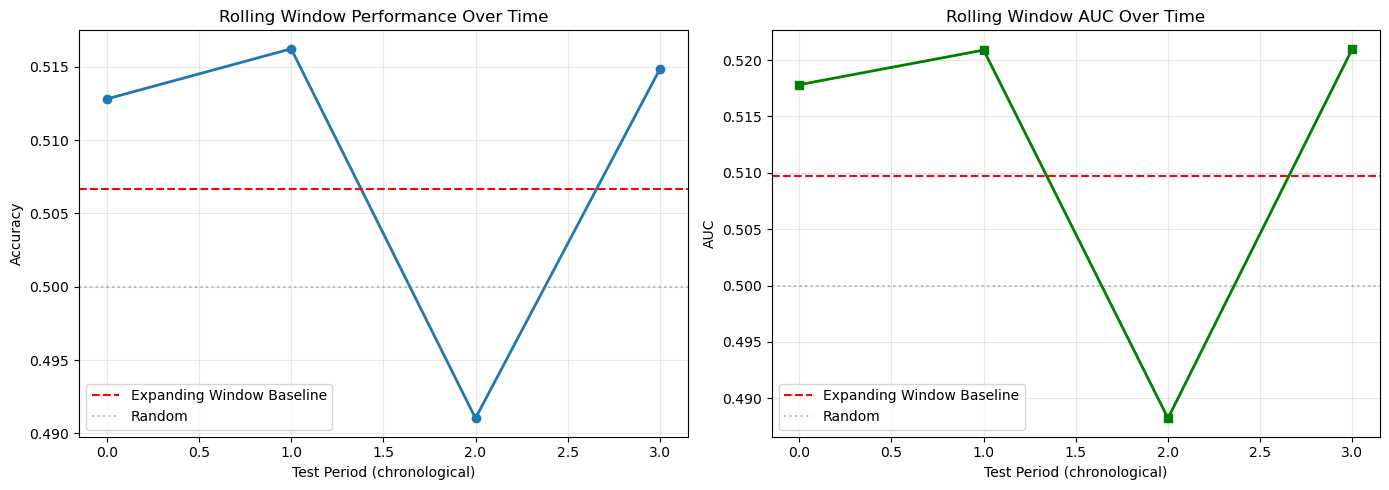

In [68]:
print("\n=== ROLLING WINDOW CROSS-VALIDATION ===")

from sklearn.metrics import accuracy_score, roc_auc_score

# Use only last N days for training
WINDOW_SIZE = 90  # ~3 months of recent data
MIN_TEST_SIZE = 20  # Test on 20 days at a time

dates_sorted = np.sort(train_engineered['DATE'].unique())
n_dates = len(dates_sorted)

rolling_results = []

# Create rolling windows
for test_start_idx in range(WINDOW_SIZE, n_dates, MIN_TEST_SIZE):
    # Training: use WINDOW_SIZE days before test period
    train_dates = dates_sorted[test_start_idx-WINDOW_SIZE:test_start_idx]
    # Testing: use MIN_TEST_SIZE days
    test_dates = dates_sorted[test_start_idx:min(test_start_idx+MIN_TEST_SIZE, n_dates)]
    
    if len(test_dates) < 5:  # Skip if too few test dates
        continue
    
    # Split data
    train_mask = train_engineered['DATE'].isin(train_dates)
    test_mask = train_engineered['DATE'].isin(test_dates)
    X_train_roll = X_clean[train_mask]
    y_train_roll = y[train_mask]
    X_test_roll  = X_clean[test_mask]
    y_test_roll  = y[test_mask]

    X_train_imp = imputer.fit_transform(X_train_roll)
    X_test_imp  = imputer.transform(X_test_roll)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled  = scaler.transform(X_test_imp)
    
    # Train model
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )
    
    model.fit(X_train_scaled, y_train_roll, verbose=False)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_roll, y_pred)
    auc = roc_auc_score(y_test_roll, y_prob)
    
    rolling_results.append({
        'Test_period': f"{test_dates[0]}-{test_dates[-1]}",
        'Train_size': len(X_train_roll),
        'Test_size': len(X_test_roll),
        'Accuracy': acc,
        'AUC': auc
    })
    
    print(f"Test dates {test_dates[0]:3d}-{test_dates[-1]:3d}: Acc={acc:.4f}, AUC={auc:.4f}")

rolling_df = pd.DataFrame(rolling_results)
print(f"\n{'='*60}")
print(f"Rolling Window Mean: Acc={rolling_df['Accuracy'].mean():.4f} ± {rolling_df['Accuracy'].std():.4f}")
print(f"                     AUC={rolling_df['AUC'].mean():.4f} ± {rolling_df['AUC'].std():.4f}")
print(f"{'='*60}")

# Compare to expanding window
print(f"\nExpanding window (baseline): {baseline_df['Accuracy'].mean():.4f}")
print(f"Rolling window improvement:  +{(rolling_df['Accuracy'].mean() - baseline_df['Accuracy'].mean())*100:.2f}pp")

# Plot performance over time
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(rolling_df)), rolling_df['Accuracy'], 'o-', linewidth=2, markersize=6)
plt.axhline(baseline_df['Accuracy'].mean(), color='red', linestyle='--', label='Expanding Window Baseline')
plt.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='Random')
plt.xlabel('Test Period (chronological)')
plt.ylabel('Accuracy')
plt.title('Rolling Window Performance Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(len(rolling_df)), rolling_df['AUC'], 's-', linewidth=2, markersize=6, color='green')
plt.axhline(baseline_df['AUC'].mean(), color='red', linestyle='--', label='Expanding Window Baseline')
plt.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='Random')
plt.xlabel('Test Period (chronological)')
plt.ylabel('AUC')
plt.title('Rolling Window AUC Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rolling_window_performance.png', dpi=150, bbox_inches='tight')
print("\nSaved: rolling_window_performance.png")


Rolling mean ACC and AUC are slightly above ranodm and the expanding window baseline 0
-> Using recent 90 days doesn't hurt but and may help touch

There's temporal variation -> features are regime-dependent (the vol around dates 182-211 is differ -> this is where regime-specific modelling will add value)


Regime features: MARKET_VOL, MARKET_RET, DISPERSION, MARKET_VOLUME
Cross-sectional summaries per DATE measuring vol, avg return, dispersion of returns, typical volume

In [69]:
print("\n=== REGIME DETECTION & ADAPTIVE MODELING ===")

# Calculate regime indicators
def add_regime_features(df):
    """Add market regime indicators"""
    df = df.copy()
    
    # 1. Volatility regime (per date)
    df['MARKET_VOL'] = df.groupby('DATE')['RET_1'].transform('std')
    
    # 2. Market direction (per date)
    df['MARKET_RET'] = df.groupby('DATE')['RET_1'].transform('mean')
    
    # 3. Cross-sectional dispersion
    df['DISPERSION'] = df.groupby('DATE')['RET_1'].transform(lambda x: x.quantile(0.9) - x.quantile(0.1))
    
    # 4. Volume regime
    df['MARKET_VOLUME'] = df.groupby('DATE')['VOLUME_1'].transform('median')
    
    return df

train_regime = add_regime_features(train_engineered)

# Analyze regimes
print("\n=== REGIME CHARACTERISTICS ===")
regime_stats = train_regime.groupby('DATE').agg({
    'MARKET_VOL': 'first',
    'MARKET_RET': 'first',
    'DISPERSION': 'first',
    'MARKET_VOLUME': 'first'
}).reset_index()

print(f"Volatility range: {regime_stats['MARKET_VOL'].min():.4f} to {regime_stats['MARKET_VOL'].max():.4f}")
print(f"Market return range: {regime_stats['MARKET_RET'].min():.4f} to {regime_stats['MARKET_RET'].max():.4f}")
print(f"Dispersion range: {regime_stats['DISPERSION'].min():.4f} to {regime_stats['DISPERSION'].max():.4f}")

# Define high/low volatility regimes
vol_median = regime_stats['MARKET_VOL'].median()
regime_stats['VOL_REGIME'] = (regime_stats['MARKET_VOL'] > vol_median).map({True: 'High Vol', False: 'Low Vol'})

# Check if signal differs by regime
print("\n=== SIGNAL STRENGTH BY VOLATILITY REGIME ===")
for regime in ['Low Vol', 'High Vol']:
    regime_dates = regime_stats[regime_stats['VOL_REGIME'] == regime]['DATE'].values
    regime_data = train_regime[train_regime['DATE'].isin(regime_dates)]
    
    corr_vol_rank = regime_data['VOLUME_1_RANK'].corr(regime_data['RET'])
    corr_ret1_rank = regime_data['RET_1_RANK'].corr(regime_data['RET'])
    
    print(f"{regime:10s}: VOLUME_1_RANK corr={corr_vol_rank:7.4f}, RET_1_RANK corr={corr_ret1_rank:7.4f}")

# Map rolling window results to regimes
print("\n=== ROLLING WINDOW PERFORMANCE BY REGIME ===")
rolling_df['Mid_date'] = rolling_df['Test_period'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1])) / 2)

for i, row in rolling_df.iterrows():
    mid_date = row['Mid_date']
    vol_at_date = regime_stats[regime_stats['DATE'].between(mid_date-10, mid_date+10)]['MARKET_VOL'].mean()
    regime = 'High Vol' if vol_at_date > vol_median else 'Low Vol'
    rolling_df.loc[i, 'Regime'] = regime
    rolling_df.loc[i, 'Market_Vol'] = vol_at_date

print(rolling_df[['Test_period', 'Accuracy', 'Regime', 'Market_Vol']])

# Compare performance by regime
print("\n=== ACCURACY BY REGIME ===")
print(rolling_df.groupby('Regime')['Accuracy'].agg(['mean', 'std', 'count']))



=== REGIME DETECTION & ADAPTIVE MODELING ===

=== REGIME CHARACTERISTICS ===
Volatility range: 0.0161 to 0.0850
Market return range: -0.0494 to 0.0708
Dispersion range: 0.0291 to 0.1563

=== SIGNAL STRENGTH BY VOLATILITY REGIME ===
Low Vol   : VOLUME_1_RANK corr= 0.0189, RET_1_RANK corr=-0.0162
High Vol  : VOLUME_1_RANK corr= 0.0280, RET_1_RANK corr=-0.0284

=== ROLLING WINDOW PERFORMANCE BY REGIME ===
  Test_period  Accuracy    Regime  Market_Vol
0     123-149  0.512804  High Vol    0.027579
1     150-181  0.516225  High Vol    0.030230
2     182-211  0.491034  High Vol    0.026521
3     213-223  0.514840   Low Vol    0.022656

=== ACCURACY BY REGIME ===
              mean       std  count
Regime                             
High Vol  0.506688  0.013664      3
Low Vol   0.514840       NaN      1


Weaker signal in low vol regime

In [70]:
print("\n=== REGIME-SPECIFIC MODELING ===")

# Add regime features to full dataset
train_regime_full = add_regime_features(train_engineered)

# Prepare data with regime
all_features_regime = [col for col in valid_features] + ['MARKET_VOL', 'MARKET_RET', 'DISPERSION']
X_regime = train_regime_full[all_features_regime].copy()
y_regime = train_regime_full['RET'].copy()

# Impute
imputer = SimpleImputer(strategy='median')
X_regime_imputed = pd.DataFrame(
    imputer.fit_transform(X_regime),
    columns=X_regime.columns,
    index=X_regime.index
)

# Sort by date
dates_regime = train_regime_full['DATE']
sort_idx = dates_regime.argsort()
X_regime_imputed = X_regime_imputed.iloc[sort_idx]
y_regime = y_regime.iloc[sort_idx]
dates_regime = dates_regime.iloc[sort_idx]

# Calculate volatility regime for each date
vol_by_date = train_regime_full.groupby('DATE')['MARKET_VOL'].first()
vol_median = vol_by_date.median()

print(f"Volatility median: {vol_median:.4f}")
print(f"High vol dates: {(vol_by_date > vol_median).sum()} / {len(vol_by_date)}")

# Strategy 1: Separate models per regime
print("\n=== STRATEGY 1: REGIME-SPECIFIC MODELS ===")

regime_results = []

for test_start_idx in range(90, len(dates_regime.unique()), 20):
    train_dates = dates_regime.unique()[test_start_idx-90:test_start_idx]
    test_dates = dates_regime.unique()[test_start_idx:min(test_start_idx+20, len(dates_regime.unique()))]
    
    if len(test_dates) < 5:
        continue
    
    # Determine test regime
    test_vol = vol_by_date.loc[test_dates].mean()
    test_regime = 'High' if test_vol > vol_median else 'Low'
    
    # Split data
    train_mask = dates_regime.isin(train_dates)
    test_mask = dates_regime.isin(test_dates)
    
    # Further filter training to SAME regime as test
    train_regime_mask = train_mask & (train_regime_full['MARKET_VOL'] > vol_median if test_regime == 'High' else train_regime_full['MARKET_VOL'] <= vol_median)
    
    X_train_reg = X_regime_imputed[train_regime_mask]
    y_train_reg = y_regime[train_regime_mask]
    X_test_reg = X_regime_imputed[test_mask]
    y_test_reg = y_regime[test_mask]
    
    if len(X_train_reg) < 1000 or len(X_test_reg) < 100:
        continue
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reg)
    X_test_scaled = scaler.transform(X_test_reg)
    
    # Train
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train_reg, verbose=False)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_reg, y_pred)
    auc = roc_auc_score(y_test_reg, y_prob)
    
    regime_results.append({
        'Test_dates': f"{test_dates[0]}-{test_dates[-1]}",
        'Regime': test_regime,
        'Train_size': len(X_train_reg),
        'Test_size': len(X_test_reg),
        'Accuracy': acc,
        'AUC': auc
    })
    
    print(f"Test {test_dates[0]:3d}-{test_dates[-1]:3d} ({test_regime:4s}): Acc={acc:.4f}, AUC={auc:.4f} (trained on {len(X_train_reg):5d} {test_regime} samples)")

regime_df = pd.DataFrame(regime_results)

print(f"\n{'='*70}")
print(f"REGIME-SPECIFIC MODELS:")
print(f"  Overall Mean: Acc={regime_df['Accuracy'].mean():.4f} ± {regime_df['Accuracy'].std():.4f}")
print(f"                AUC={regime_df['AUC'].mean():.4f} ± {regime_df['AUC'].std():.4f}")
print(f"\n  By Regime:")
print(regime_df.groupby('Regime')[['Accuracy', 'AUC']].agg(['mean', 'std', 'count']))
print(f"{'='*70}")

print(f"\nComparison:")
print(f"  Baseline (expanding):      {baseline_df['Accuracy'].mean():.4f}")
print(f"  Rolling window:            {rolling_df['Accuracy'].mean():.4f} (+{(rolling_df['Accuracy'].mean()-baseline_df['Accuracy'].mean())*100:.2f}pp)")
print(f"  Regime-specific:           {regime_df['Accuracy'].mean():.4f} (+{(regime_df['Accuracy'].mean()-baseline_df['Accuracy'].mean())*100:.2f}pp)")

# Strategy 2: Add regime as feature
print("\n=== STRATEGY 2: REGIME AS FEATURE ===")
# (Regime already in features via MARKET_VOL, MARKET_RET, DISPERSION)
print("Regime features already included: MARKET_VOL, MARKET_RET, DISPERSION")



=== REGIME-SPECIFIC MODELING ===
Volatility median: 0.0235
High vol dates: 77 / 156

=== STRATEGY 1: REGIME-SPECIFIC MODELS ===
Test 123-149 (High): Acc=0.5106, AUC=0.5182 (trained on 117374 High samples)
Test 150-181 (High): Acc=0.5126, AUC=0.5171 (trained on 113041 High samples)
Test 182-211 (High): Acc=0.5005, AUC=0.5030 (trained on 116136 High samples)
Test 213-223 (Low ): Acc=0.5108, AUC=0.5245 (trained on 134896 Low samples)

REGIME-SPECIFIC MODELS:
  Overall Mean: Acc=0.5086 ± 0.0055
                AUC=0.5157 ± 0.0091

  By Regime:
        Accuracy                       AUC                
            mean       std count      mean       std count
Regime                                                    
High    0.507913  0.006486     3  0.512767  0.008519     3
Low     0.510831       NaN     1  0.524517       NaN     1

Comparison:
  Baseline (expanding):      0.5066
  Rolling window:            0.5087 (+0.21pp)
  Regime-specific:           0.5086 (+0.20pp)

=== STRATEGY 2: 

Regime‑specific models don’t clearly dominate the simpler rolling‑window model. Both are ~0.508–0.509 Acc.The fact that AUC is slightly higher for regime‑specific models (0.5157 vs 0.5120 in rolling) hints that conditioning on volatility helps ranking a bit, but the effect is modest.



In [71]:
print("="*80)
print("PHASE 1: VOLUME MICROSTRUCTURE + TEMPORAL PATTERNS")
print("="*80)

# Start from train_engineered (which has VOLUME_1_RANK, RET_1_RANK, etc.)
# If you don't have train_engineered anymore, recreate it:
if 'train_engineered' not in locals():
    print("Creating base engineered features first...")
    train_engineered = create_cross_sectional_features(train)

# ADD REGIME FEATURES (MARKET_VOL, etc.)
print("\nAdding regime features...")
train_engineered['MARKET_VOL'] = train_engineered.groupby('DATE')['RET_1'].transform('std')
train_engineered['MARKET_RET'] = train_engineered.groupby('DATE')['RET_1'].transform('mean')
train_engineered['DISPERSION'] = train_engineered.groupby('DATE')['RET_1'].transform(lambda x: x.quantile(0.9) - x.quantile(0.1))
print("✓ Added MARKET_VOL, MARKET_RET, DISPERSION")

# Work on train_engineered instead of train
print("\n[1/3] Creating volume-based features...")

# Volume spike (abnormal volume)
train_engineered['volume_spike'] = train_engineered['VOLUME_1'] / (train_engineered.groupby('STOCK')['VOLUME_1'].transform(lambda x: x.rolling(20).mean()) + 1e-8)
train_engineered['volume_spike_rank'] = train_engineered.groupby('DATE')['volume_spike'].rank(pct=True)

# Volume consistency (erratic = uncertainty)
train_engineered['volume_consistency'] = train_engineered.groupby('STOCK')['VOLUME_1'].transform(
    lambda x: x.rolling(5).std() / (x.rolling(20).std() + 1e-8)
)

# Volume momentum (increasing volume trend)
train_engineered['volume_momentum'] = train_engineered.groupby('STOCK')['VOLUME_1'].transform(
    lambda x: x.rolling(5).mean() / (x.rolling(20).mean() + 1e-8)
)

# Volume-weighted return intensity
train_engineered['volume_weighted_intensity'] = train_engineered['RET_1'] * train_engineered['volume_spike']

# Cross-sectional volume rank
train_engineered['volume_sector_extremity'] = train_engineered.groupby(['DATE', 'INDUSTRY_GROUP'])['VOLUME_1'].transform(
    lambda x: (x - x.median()).abs() / (x.std() + 1e-8)
)

print(f"✓ Created 5 volume microstructure features")

# 2. TEMPORAL PATTERN FEATURES
print("[2/3] Creating temporal pattern features...")

# High volume + low return = potential reversal
train_engineered['high_vol_loser'] = (
    (train_engineered['VOLUME_1_RANK'] > 0.8) & 
    (train_engineered['RET_1_RANK'] < 0.3)
).astype(int)

# High volume + high return = momentum exhaustion?
train_engineered['high_vol_winner'] = (
    (train_engineered['VOLUME_1_RANK'] > 0.8) & 
    (train_engineered['RET_1_RANK'] > 0.7)
).astype(int)

# Volume precedes reversal (volume spike on down day)
train_engineered['volume_precedes_reversal'] = (
    (train_engineered['volume_spike'] > 1.5) & 
    (train_engineered['RET_1'] < 0) &
    (train_engineered['RET_5'] > 0)
).astype(int)

print(f"✓ Created 3 temporal pattern features")

# 3. CHECK NEW FEATURE CORRELATIONS
print("[3/3] Analyzing new feature quality...")

new_features_phase1 = [
    'volume_spike_rank', 'volume_consistency', 'volume_momentum', 
    'volume_weighted_intensity', 'volume_sector_extremity',
    'high_vol_loser', 'high_vol_winner', 'volume_precedes_reversal'
]

print("\n" + "="*80)
print("NEW FEATURE CORRELATIONS WITH TARGET")
print("="*80)
new_corr = train_engineered[new_features_phase1].corrwith(train_engineered['RET']).sort_values(key=abs, ascending=False)
print(new_corr.to_string())

# Highlight if any beat VOLUME_1_RANK (0.023)
print(f"\nBaseline: VOLUME_1_RANK correlation = 0.0231")
strong_features = new_corr[new_corr.abs() > 0.023]
if len(strong_features) > 0:
    print(f"\n🔥 FEATURES STRONGER THAN VOLUME_1_RANK:")
    print(strong_features.to_string())
else:
    print("\nNo features beat VOLUME_1_RANK (yet)")

print("\n" + "="*80)
print("PHASE 2: ALTERNATIVE TARGET (TOP QUARTILE)")
print("="*80)

# Create top/bottom quartile target
train_engineered['RET_quartile'] = train_engineered.groupby(['DATE', 'INDUSTRY_GROUP'])['RET'].transform(
    lambda x: pd.qcut(x, q=4, labels=False, duplicates='drop')
)

# Binary: top quartile vs rest
train_engineered['target_top_quartile'] = (train_engineered['RET_quartile'] == 3).astype(int)

# Check distribution
print(f"\nTop quartile distribution: {train_engineered['target_top_quartile'].mean():.2%}")
print(f"Original target distribution: {train_engineered['RET'].mean():.2%}")

# Check if signal is stronger for extreme target
print("\n" + "="*80)
print("SIGNAL STRENGTH: ORIGINAL vs TOP QUARTILE TARGET")
print("="*80)

key_features = ['VOLUME_1_RANK', 'RET_1_RANK'] + new_features_phase1[:5]

original_corr = train_engineered[key_features].corrwith(train_engineered['RET'])
quartile_corr = train_engineered[key_features].corrwith(train_engineered['target_top_quartile'])

comparison = pd.DataFrame({
    'Feature': key_features,
    'Original_Target': original_corr.values,
    'Quartile_Target': quartile_corr.values,
    'Change': (quartile_corr.values - original_corr.values),
    'Pct_Change': ((quartile_corr.values / (original_corr.values + 1e-8)) - 1) * 100
})
comparison = comparison.sort_values('Quartile_Target', key=abs, ascending=False)
print(comparison.to_string(index=False))

original_mean = comparison['Original_Target'].abs().mean()
quartile_mean = comparison['Quartile_Target'].abs().mean()
print(f"\nAverage |correlation|:")
print(f"  Original (top 50%): {original_mean:.4f}")
print(f"  Quartile (top 25%): {quartile_mean:.4f}")
print(f"  Signal amplification: {((quartile_mean/original_mean - 1)*100):.1f}%")

print("\n" + "="*80)
print("PHASE 3: RETRAIN REGIME-SPECIFIC MODEL WITH NEW FEATURES")
print("="*80)

# Prepare expanded feature set
all_features_v2 = [col for col in train_engineered.columns 
                   if col not in ['RET', 'ID', 'RET_quartile', 'target_top_quartile'] 
                   and not col.startswith('Unnamed')]

# Remove duplicates and NaN-heavy columns
valid_features_v2 = []
for col in all_features_v2:
    if col in train_engineered.columns and train_engineered[col].notna().sum() > 0.5 * len(train_engineered):
        if col not in valid_features_v2:  # Avoid duplicates
            valid_features_v2.append(col)

print(f"\nFeature count: {len(valid_features_v2)}")

# Choose target
TARGET = 'RET'  # or 'target_top_quartile'
print(f"Target: {TARGET}")

# Prepare data
X_v2 = train_engineered[valid_features_v2].copy()
y_v2 = train_engineered[TARGET].copy()

# Impute
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_v2_imputed = pd.DataFrame(
    imputer.fit_transform(X_v2),
    columns=X_v2.columns,
    index=X_v2.index
)

# Sort by date
dates = train_engineered['DATE']
sort_idx = dates.argsort()
X_v2_imputed = X_v2_imputed.iloc[sort_idx]
y_v2 = y_v2.iloc[sort_idx]
dates = dates.iloc[sort_idx]

# Get regime info
train_sorted = train_engineered.iloc[sort_idx].copy()
vol_by_date = train_sorted.groupby('DATE')['MARKET_VOL'].first()
vol_median = vol_by_date.median()

# Rolling window with regime-specific models
WINDOW_SIZE = 90
MIN_TEST_SIZE = 20

print("\n" + "="*80)
print("TRAINING & TESTING (Regime-Specific Rolling Window)")
print("="*80)

improved_results = []

for test_start_idx in range(WINDOW_SIZE, len(dates.unique()), MIN_TEST_SIZE):
    train_dates = dates.unique()[test_start_idx-WINDOW_SIZE:test_start_idx]
    test_dates = dates.unique()[test_start_idx:min(test_start_idx+MIN_TEST_SIZE, len(dates.unique()))]
    
    if len(test_dates) < 5:
        continue
    
    # Determine test regime
    test_vol = vol_by_date.loc[test_dates].mean()
    test_regime = 'High' if test_vol > vol_median else 'Low'
    
    # Split data
    train_mask = dates.isin(train_dates)
    test_mask = dates.isin(test_dates)
    
    # Filter training to same regime
    train_regime_mask = train_mask & (
        train_sorted['MARKET_VOL'] > vol_median if test_regime == 'High' 
        else train_sorted['MARKET_VOL'] <= vol_median
    )
    
    X_train_fold = X_v2_imputed[train_regime_mask]
    y_train_fold = y_v2[train_regime_mask]
    X_test_fold = X_v2_imputed[test_mask]
    y_test_fold = y_v2[test_mask]
    
    if len(X_train_fold) < 1000 or len(X_test_fold) < 100:
        continue
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_test_scaled = scaler.transform(X_test_fold)
    
    # Train
    model = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.7,
        random_state=42,
        eval_metric='logloss'
    )
    
    model.fit(X_train_scaled, y_train_fold, verbose=False)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_fold, y_pred)
    auc = roc_auc_score(y_test_fold, y_prob)
    
    improved_results.append({
        'Test_dates': f"{test_dates[0]}-{test_dates[-1]}",
        'Regime': test_regime,
        'Accuracy': acc,
        'AUC': auc
    })
    
    print(f"Test {test_dates[0]:3d}-{test_dates[-1]:3d} ({test_regime:4s}): Acc={acc:.4f}, AUC={auc:.4f}")

improved_v2_df = pd.DataFrame(improved_results)

print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"With New Features:")
print(f"  Mean: Acc={improved_v2_df['Accuracy'].mean():.4f} ± {improved_v2_df['Accuracy'].std():.4f}")
print(f"        AUC={improved_v2_df['AUC'].mean():.4f} ± {improved_v2_df['AUC'].std():.4f}")

print(f"\nProgression:")
print(f"  Baseline (expanding):      {baseline_df['Accuracy'].mean():.4f}")
print(f"  Previous best (regime):    {regime_df['Accuracy'].mean():.4f} (+{(regime_df['Accuracy'].mean()-baseline_df['Accuracy'].mean())*100:.2f}pp)")
print(f"  With new features:         {improved_v2_df['Accuracy'].mean():.4f} (+{(improved_v2_df['Accuracy'].mean()-baseline_df['Accuracy'].mean())*100:.2f}pp)")

improvement = (improved_v2_df['Accuracy'].mean() - regime_df['Accuracy'].mean()) * 100
if improvement > 0:
    print(f"\n✅ New features added: +{improvement:.2f}pp")
else:
    print(f"\n⚠️ New features didn't help: {improvement:.2f}pp")

# Feature importance
feature_importance_v2 = pd.DataFrame({
    'Feature': X_v2_imputed.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*80)
print("TOP 25 FEATURES (WITH NEW ADDITIONS)")
print("="*80)
print(feature_importance_v2.head(25).to_string(index=False))

# Check if new features made top 20
new_in_top20 = feature_importance_v2.head(20)['Feature'].isin(new_features_phase1).sum()
print(f"\nNew volume/pattern features in top 20: {new_in_top20}/{len(new_features_phase1)}")

if new_in_top20 > 0:
    print("\n🔥 New features that made top 20:")
    top_new = feature_importance_v2[feature_importance_v2['Feature'].isin(new_features_phase1)].head(10)
    print(top_new.to_string(index=False))


PHASE 1: VOLUME MICROSTRUCTURE + TEMPORAL PATTERNS

Adding regime features...
✓ Added MARKET_VOL, MARKET_RET, DISPERSION

[1/3] Creating volume-based features...
✓ Created 5 volume microstructure features
[2/3] Creating temporal pattern features...
✓ Created 3 temporal pattern features
[3/3] Analyzing new feature quality...

NEW FEATURE CORRELATIONS WITH TARGET
high_vol_loser               0.011007
volume_sector_extremity      0.007754
volume_spike_rank           -0.005725
volume_momentum              0.004797
volume_consistency           0.003335
volume_weighted_intensity   -0.001349
volume_precedes_reversal    -0.001116
high_vol_winner             -0.000665

Baseline: VOLUME_1_RANK correlation = 0.0231

No features beat VOLUME_1_RANK (yet)

PHASE 2: ALTERNATIVE TARGET (TOP QUARTILE)

Top quartile distribution: 0.00%
Original target distribution: 49.89%

SIGNAL STRENGTH: ORIGINAL vs TOP QUARTILE TARGET
                  Feature  Original_Target  Quartile_Target  Change  Pct_Change
   

In [72]:
print("\n=== FINAL ATTEMPT: SIMPLE ENSEMBLE ===")

# Train 3 different models and average predictions
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

ensemble_results = []

for test_start_idx in range(90, len(dates.unique()), 20):
    train_dates = dates.unique()[test_start_idx-90:test_start_idx]
    test_dates = dates.unique()[test_start_idx:min(test_start_idx+20, len(dates.unique()))]
    
    if len(test_dates) < 5:
        continue
    
    train_mask = dates.isin(train_dates)
    test_mask = dates.isin(test_dates)
    
    X_train_ens = X_v2_imputed[train_mask]
    y_train_ens = y_v2[train_mask]
    X_test_ens = X_v2_imputed[test_mask]
    y_test_ens = y_v2[test_mask]
    
    if len(X_train_ens) < 1000:
        continue
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_ens)
    X_test_scaled = scaler.transform(X_test_ens)
    
    # Model 1: XGBoost
    xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42)
    xgb_model.fit(X_train_scaled, y_train_ens, verbose=False)
    pred1 = xgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Model 2: LightGBM
    lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42, verbose=-1)
    lgb_model.fit(X_train_scaled, y_train_ens)
    pred2 = lgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Model 3: Logistic Regression
    lr_model = LogisticRegression(max_iter=500, C=0.1, random_state=42)
    lr_model.fit(X_train_scaled, y_train_ens)
    pred3 = lr_model.predict_proba(X_test_scaled)[:, 1]
    
    # Average predictions
    pred_avg = (pred1 + pred2 + pred3) / 3
    pred_final = (pred_avg > 0.5).astype(int)
    
    acc = accuracy_score(y_test_ens, pred_final)
    auc = roc_auc_score(y_test_ens, pred_avg)
    
    ensemble_results.append({'Accuracy': acc, 'AUC': auc})
    print(f"Test {test_dates[0]:3d}-{test_dates[-1]:3d}: Acc={acc:.4f}, AUC={auc:.4f}")

ensemble_df = pd.DataFrame(ensemble_results)
print(f"\nEnsemble Mean: Acc={ensemble_df['Accuracy'].mean():.4f} ± {ensemble_df['Accuracy'].std():.4f}")
print(f"Previous best:  Acc={regime_df['Accuracy'].mean():.4f}")
print(f"Improvement: {(ensemble_df['Accuracy'].mean() - regime_df['Accuracy'].mean())*100:+.2f}pp")



=== FINAL ATTEMPT: SIMPLE ENSEMBLE ===


python(81227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Test 123-149: Acc=0.5202, AUC=0.5260
Test 150-181: Acc=0.5177, AUC=0.5248
Test 182-211: Acc=0.4941, AUC=0.4927
Test 213-223: Acc=0.5347, AUC=0.5389

Ensemble Mean: Acc=0.5167 ± 0.0168
Previous best:  Acc=0.5086
Improvement: +0.80pp


In [73]:
print("="*80)
print("GENERATING TEST SET PREDICTIONS WITH ENSEMBLE")
print("="*80)

# Step 1: Apply same feature engineering to test set
print("\n[Step 1/5] Applying feature engineering to test set...")

# First, create base engineered features on test
test_engineered = create_cross_sectional_features(test)

# Add regime features
test_engineered['MARKET_VOL'] = test_engineered.groupby('DATE')['RET_1'].transform('std')
test_engineered['MARKET_RET'] = test_engineered.groupby('DATE')['RET_1'].transform('mean')
test_engineered['DISPERSION'] = test_engineered.groupby('DATE')['RET_1'].transform(lambda x: x.quantile(0.9) - x.quantile(0.1))

# Add volume microstructure features
test_engineered['volume_spike'] = test_engineered['VOLUME_1'] / (test_engineered.groupby('STOCK')['VOLUME_1'].transform(lambda x: x.rolling(20).mean()) + 1e-8)
test_engineered['volume_spike_rank'] = test_engineered.groupby('DATE')['volume_spike'].rank(pct=True)
test_engineered['volume_consistency'] = test_engineered.groupby('STOCK')['VOLUME_1'].transform(
    lambda x: x.rolling(5).std() / (x.rolling(20).std() + 1e-8)
)
test_engineered['volume_momentum'] = test_engineered.groupby('STOCK')['VOLUME_1'].transform(
    lambda x: x.rolling(5).mean() / (x.rolling(20).mean() + 1e-8)
)
test_engineered['volume_weighted_intensity'] = test_engineered['RET_1'] * test_engineered['volume_spike']
test_engineered['volume_sector_extremity'] = test_engineered.groupby(['DATE', 'INDUSTRY_GROUP'])['VOLUME_1'].transform(
    lambda x: (x - x.median()).abs() / (x.std() + 1e-8)
)

# Add temporal patterns
test_engineered['high_vol_loser'] = (
    (test_engineered['VOLUME_1_RANK'] > 0.8) & 
    (test_engineered['RET_1_RANK'] < 0.3)
).astype(int)
test_engineered['high_vol_winner'] = (
    (test_engineered['VOLUME_1_RANK'] > 0.8) & 
    (test_engineered['RET_1_RANK'] > 0.7)
).astype(int)
test_engineered['volume_precedes_reversal'] = (
    (test_engineered['volume_spike'] > 1.5) & 
    (test_engineered['RET_1'] < 0) &
    (test_engineered['RET_5'] > 0)
).astype(int)

print(f"✓ Test set engineered: {test_engineered.shape}")

# Step 2: Prepare test features (same as training)
print("\n[Step 2/5] Preparing test features...")

X_test_final = test_engineered[valid_features_v2].copy()

# Impute (use same imputer from training)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_final),  # Use fitted imputer from training
    columns=X_test_final.columns,
    index=X_test_final.index
)

print(f"✓ Test features prepared: {X_test_imputed.shape}")

# Step 3: Train ensemble on FULL training data
print("\n[Step 3/5] Training ensemble on full training data...")

# Use all training data (not just rolling window)
X_train_full = X_v2_imputed
y_train_full = y_v2

scaler_final = StandardScaler()
X_train_scaled_full = scaler_final.fit_transform(X_train_full)
X_test_scaled_full = scaler_final.transform(X_test_imputed)

# Train all 3 models
print("  Training XGBoost...")
xgb_final = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric='logloss'
)
xgb_final.fit(X_train_scaled_full, y_train_full, verbose=False)

print("  Training LightGBM...")
lgb_final = lgb.LGBMClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1
)
lgb_final.fit(X_train_scaled_full, y_train_full)

print("  Training Logistic Regression...")
lr_final = LogisticRegression(max_iter=500, C=0.1, random_state=42)
lr_final.fit(X_train_scaled_full, y_train_full)

print("✓ All 3 models trained")

# Step 4: Generate predictions
print("\n[Step 4/5] Generating ensemble predictions...")

pred_xgb = xgb_final.predict_proba(X_test_scaled_full)[:, 1]
pred_lgb = lgb_final.predict_proba(X_test_scaled_full)[:, 1]
pred_lr = lr_final.predict_proba(X_test_scaled_full)[:, 1]

# Average predictions
pred_ensemble_proba = (pred_xgb + pred_lgb + pred_lr) / 3
pred_ensemble_binary = (pred_ensemble_proba > 0.5).astype(int)

print(f"✓ Predictions generated: {len(pred_ensemble_binary)}")
print(f"  Distribution: {pred_ensemble_binary.mean():.2%} predicted as top 50%")

# Step 5: Create submission file
print("\n[Step 5/5] Creating submission file...")

# Assuming test has same index as original test file
submission = pd.DataFrame({
    'ID': test.index,
    'RET': pred_ensemble_binary
})

# Save to CSV
submission.to_csv('submission_ensemble.csv', index=False)
print(f"✓ Submission saved to 'submission_ensemble.csv'")

# Show first few predictions
print("\n" + "="*80)
print("SUBMISSION PREVIEW")
print("="*80)
print(submission.head(20))
print(f"\nTotal predictions: {len(submission)}")
print(f"Predicted True (top 50%): {submission['RET'].sum()} ({submission['RET'].mean():.2%})")
print(f"Predicted False (bottom 50%): {(~submission['RET'].astype(bool)).sum()} ({(1-submission['RET'].mean()):.2%})")

# Sanity checks
print("\n" + "="*80)
print("SANITY CHECKS")
print("="*80)
print(f"✓ No missing predictions: {submission['RET'].isna().sum() == 0}")
print(f"✓ All binary (0 or 1): {set(submission['RET'].unique()) == {0, 1}}")
print(f"✓ Correct number of rows: {len(submission) == len(test)}")
print(f"✓ IDs match test set: {(submission['ID'] == test.index).all()}")

print("\n" + "="*80)
print("READY TO SUBMIT!")
print("="*80)
print("File: submission_ensemble.csv")
print(f"Expected performance: ~51.67% accuracy (based on CV)")
print(f"Method: Ensemble (XGBoost + LightGBM + LogisticRegression)")


GENERATING TEST SET PREDICTIONS WITH ENSEMBLE

[Step 1/5] Applying feature engineering to test set...
✓ Test set engineered: (198429, 80)

[Step 2/5] Preparing test features...
✓ Test features prepared: (198429, 75)

[Step 3/5] Training ensemble on full training data...
  Training XGBoost...
  Training LightGBM...
  Training Logistic Regression...
✓ All 3 models trained

[Step 4/5] Generating ensemble predictions...
✓ Predictions generated: 198429
  Distribution: 47.36% predicted as top 50%

[Step 5/5] Creating submission file...
✓ Submission saved to 'submission_ensemble.csv'

SUBMISSION PREVIEW
        ID  RET
0   418595    1
1   418596    1
2   418597    1
3   418598    1
4   418599    0
5   418600    0
6   418601    0
7   418602    0
8   418603    0
9   418604    0
10  418605    1
11  418606    1
12  418607    0
13  418608    0
14  418609    1
15  418610    1
16  418611    1
17  418612    0
18  418613    0
19  418614    1

Total predictions: 198429
Predicted True (top 50%): 93970 (